In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import PyPDF2
import tabula
import os
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
# Константы для загрузки из бюллетеней
URL = 'https://www.cbr.ru/statistics/bbs/'
TABLE_PATTERN = re.compile(r".*нефинансовым\s+организациям\s+в\s+рублях")
YEAR_PATTERN = re.compile(r'202\d год')
FILE_PATH = 'downloaded_files/Bbs2405r.pdf'

# Константы для загрузки из базы данных
START_DATE = '01.01.2018'
END_DATE = '01.01.2024' 
DATA_TYPE = '/hd_base/infl/' # Тип данных для загрузки с сайта (список типов получен функцией scrape_cbr_date)

__Тетрадь PET-проекта по выгрузке информации Центрального банка.__

Выгрузка представлена двумя направлениями:
- `Выгрузка информации по процентным ставкам из ежемесячных бюллетеней (PDF)`

Cтатистические бюллетени содержат информацию, которую можно использовать для расчета стоимости заемного капитала. 

- `Выгрузка информации о ключевой ставке и инфляции с базы ЦБ РФ`

Для разработки прогнозов временных рядов может потребоваться информация об инфляции



# Выгрузка информации о процентных ставках по коммерческим кредитам из статистических бюллетеней Центрального банка РФ

Так как статистические бюллетени представляют из себя pdf файлы, сначала требуется найти их на странице, а затем скачать и найти в них нужную информацию

## Функции для поиска и загрузки банковских бюллетеней на сайте ЦБ РФ

### __`find_specific_links`__

Находит ссылки на банковские бюллетени на веб-странице Центрального Банка России (ЦБР).

**Параметры:**
- `url` (str): URL веб-страницы ЦБР, с которой необходимо извлечь ссылки на бюллетени.

**Возвращает:**
- `list`: Список строк, где каждая строка - это полный URL для скачивания конкретного бюллетеня.

### __`download_files`__

Загружает последние n банковских бюллетеней из списка предоставленных ссылок.

**Параметры:**
- `links` (list): Список URL-ссылок на банковские бюллетени, которые необходимо скачать.
- `num_files` (int, по умолчанию 4): Количество файлов, которые нужно скачать.

**Возвращает:**
- Ничего не возвращает. Скачивает файлы и сохраняет их в локальную директорию `downloaded_files`. 

**Примечание:**
Функция проверяет, существует ли уже файл, и если да, то пропускает его скачивание.

In [3]:
#Функции для поиска ссылок банковских бюллетеней на сайте ЦБ РФ
def find_specific_links(url):
    # Отправляем GET-запрос на указанный URL
    response = requests.get(url)
    response.raise_for_status()  # Проверяем, что запрос прошел успешно

    # Парсим HTML с помощью BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Собираем все ссылки на странице
    links = soup.find_all('a', href=True)

    # Подготавливаем регулярное выражение для поиска нужного формата ссылок
    pattern = re.compile(r'^/Collection/Collection/File/\d+/Bbs\d{4}r\.pdf$')

    # Фильтруем ссылки по регулярному выражению и формируем полные URL
    filtered_links = ['https://www.cbr.ru' + link['href'] for link in links if pattern.match(link['href'])]

    return filtered_links

#Функция для загрузки последних n бюллетеней из списка
def download_files(links, num_files=4):
    # Скачиваем только первые `num_files` файлов
    for link in links[:num_files]:
        file_name = link.split('/')[-1]
        save_path = os.path.join('downloaded_files', file_name)

        # Проверяем, существует ли уже файл
        if not os.path.exists(save_path):
            # Отправляем GET-запрос для скачивания файла
            response = requests.get(link)
            response.raise_for_status()

            # Сохраняем файл
            with open(save_path, 'wb') as f:
                f.write(response.content)
            print(f'Файл {file_name} был успешно скачан и сохранен в {save_path}')
        else:
            print(f'Файл {file_name} уже существует и не будет скачан заново.')

In [4]:
# Создаем папку для сохранения файлов, если она не существует
if not os.path.exists('downloaded_files'):
    os.makedirs('downloaded_files')

# Вызываем функцию для поиска ссылок
specific_links = find_specific_links(URL)

# Вызываем функцию для скачивания файлов
download_files(specific_links)

Файл Bbs2405r.pdf уже существует и не будет скачан заново.
Файл Bbs2404r.pdf уже существует и не будет скачан заново.
Файл Bbs2403r.pdf уже существует и не будет скачан заново.
Файл Bbs2402r.pdf уже существует и не будет скачан заново.


## Поиск данных в pdf

## Функции для поиска и извлечения таблиц из PDF файлов

### __`find_page_with_phrase`__

Ищет страницу в PDF файле, содержащую заданную фразу.

**Параметры:**
- `file_path` (str): Путь к PDF файлу.
- `pattern` (re.Pattern): Регулярное выражение для поиска фразы.
- `start_page` (int, по умолчанию 88): Начальная страница для поиска.
- `end_page` (int, по умолчанию 105): Конечная страница для поиска.

**Возвращает:**
- `int`: Номер страницы, на которой найдена фраза, или `None`, если фраза не найдена.

### __`extract_table_from_page`__

Извлекает таблицу из указанной страницы PDF файла и обрабатывает данные.

**Параметры:**
- `file_path` (str): Путь к PDF файлу.
- `page_number` (int): Номер страницы, с которой нужно извлечь таблицу.

**Возвращает:**
- `DataFrame`: Обработанная таблица pandas DataFrame, где индексы - это даты в формате "ГГГГ-ММ-01", а значения - процентные ставки, преобразованные в числовой формат.

In [5]:
def find_page_with_phrase(file_path, pattern, start_page=88, end_page=105):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        for page_number in range(start_page, end_page):
            page = reader.pages[page_number]
            text = page.extract_text()
            if pattern.search(text):
                print(f"Фраза найдена на странице {page_number + 1}")
                return page_number + 1
        print("Фраза не найдена на указанных страницах.")
        return None

def extract_table_from_page(file_path, page_number):
    tables = tabula.read_pdf(file_path, pages=page_number, multiple_tables=True)
    if tables:
        table = tables[0]
        df = pd.DataFrame(table)

        combined_header = df.iloc[0:4].fillna('').apply(lambda x: ' '.join(x), axis=0)
        df.columns = combined_header
        df = df.drop([0, 1, 2, 3]).reset_index(drop=True)
        df = df.iloc[:, :9]

        current_year = None
        for i in range(len(df)):
            cell_value = df.iloc[i, 0]
            if YEAR_PATTERN.match(cell_value):
                current_year = YEAR_PATTERN.findall(cell_value)[0][:4]
            else:
                month_mapping = {
                    'январь': '01',
                    'февраль': '02',
                    'март': '03',
                    'апрель': '04',
                    'май': '05',
                    'июнь': '06',
                    'июль': '07',
                    'август': '08',
                    'сентябрь': '09',
                    'октябрь': '10',
                    'ноябрь': '11',
                    'декабрь': '12'
                }
                month_name = cell_value.strip().lower()
                if month_name in month_mapping:
                    df.iloc[i, 0] = f"{current_year}-{month_mapping[month_name]}-01"

        df.set_index(df.columns[0], inplace=True)
        rates = df.dropna().drop(df.index[0]).replace(',', '.', regex=True).astype(float)
        return rates
    return None

In [6]:
# Вызов функций
found_page = find_page_with_phrase(FILE_PATH, TABLE_PATTERN)
if found_page:
    rates = extract_table_from_page(FILE_PATH, found_page)

Error importing jpype dependencies. Fallback to subprocess.
No module named 'jpype'


Фраза найдена на странице 100


,"до 30 дней, включая “до востре­ бования”",от 31 до 90 дней,от 91 до 180 дней,от 181 дня до 1 года,"до 1 года, включая “до востре­ бования”",от 1 года до 3 лет,свыше 3 лет,свыше 1 года
,,,,,,,,
2023-01-01,9.53,9.99,10.85,9.03,9.79,9.22,7.42,8.23
2023-02-01,9.19,10.15,10.85,8.59,9.54,9.59,7.64,8.95
2023-03-01,9.27,10.32,10.70,8.68,9.59,9.55,8.08,8.88
2023-04-01,9.42,10.20,10.62,9.37,9.86,9.38,8.88,9.11
2023-05-01,9.33,10.10,10.88,9.18,9.83,9.75,8.60,9.09
2023-06-01,9.16,10.10,10.40,8.34,9.46,9.70,9.30,9.47
2023-07-01,9.36,10.63,10.70,8.55,9.71,9.94,8.98,9.37
2023-08-01,10.80,11.72,12.72,12.79,12.24,11.34,11.15,11.24
2023-09-01,13.62,13.30,13.75,13.84,13.64,12.03,11.99,12.01


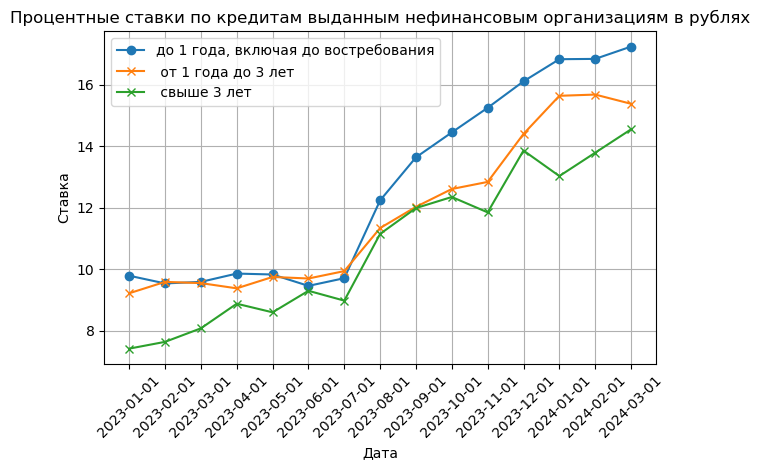

In [7]:
# Отображаем обновленный DataFrame
display(rates)

# График ключевой ставки
plt.plot(rates.index, rates['до 1 года, включая “до востре­ бования”'], marker='o', label='до 1 года, включая до востребования')
plt.plot(rates.index, rates[' от 1 года до 3 лет '], marker='x', label=' от 1 года до 3 лет ')
plt.plot(rates.index, rates[' свыше 3 лет '], marker='x', label=' свыше 3 лет ')

# Настройка графика
plt.xlabel('Дата')
plt.ylabel('Ставка')
plt.title('Процентные ставки по кредитам выданным нефинансовым организациям в рублях')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Отображение графика
plt.show()

# Выгрузка данных из базы CBR



## Получения списка данных базы

### __`scrape_cbr_data`__

Извлекает ссылки и связанные с ними имена с веб-страницы Центрального Банка России (ЦБР).

**Параметры:**
- `url` (str): URL веб-страницы ЦБР, с которой необходимо извлечь данные.

**Возвращает:**
- `DataFrame`: Таблица pandas DataFrame, содержащая два столбца - `regular_name` и `regular_name_visible`, где `regular_name` содержит ссылки, а `regular_name_visible` содержит соответствующие имена.

In [8]:
def scrape_cbr_data(url):
    # Отправляем запрос для получения HTML-контента
    response = requests.get(url)

    # Парсим HTML-контент с использованием BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Подготавливаем списки для хранения данных
    links = []
    names = []

    # Находим все теги <a> с заданным шаблоном в href
    link_tags = soup.find_all('a', href=True)
    for link in link_tags:
        href = link['href']
        if '/hd_base/' in href:
            # Извлекаем связанное имя
            parent_div = link.find_parent('div', class_='document-regular_name')
            if parent_div:
                name_tag = parent_div.find('span', class_='document-regular_name_visible')
                name = name_tag.get_text(strip=True) if name_tag else 'N/A'
            else:
                name = 'N/A'
            
            # Добавляем href и имя в списки
            links.append(href)
            names.append(name)

    # Создаем DataFrame
    df = pd.DataFrame({
        'regular_name': links,
        'regular_name_visible': names
    })
    return df

In [9]:
# Вызов функции и отображение DataFrame
df = scrape_cbr_data(URL)
display(df.head())

,regular_name,regular_name_visible


## Выгрузка из базы данных

### __`load_cbr_data`__

Загружает данные с сайта Центрального Банка России.

**Параметры:**
- `data_type` (str): Тип данных для загрузки (Полученный regular_name из функции scrape_cbr_data).
- `start_date` (str): Начальная дата в формате 'dd.mm.yyyy'.
- `end_date` (str): Конечная дата в формате 'dd.mm.yyyy'.

**Возвращает:**
- `DataFrame`: Таблица pandas DataFrame с загруженными данными.

In [10]:
def load_cbr_data(data_type, start_date, end_date):
    base_url = f'https://www.cbr.ru/{data_type}/?UniDbQuery.Posted=True'
    # Формируем полный URL с параметрами дат
    url = f"{base_url}&UniDbQuery.From={start_date}&UniDbQuery.To={end_date}"
    
    # Запрашиваем данные
    data = requests.get(url).text

    # Обрабатываем данные
    beautiful_soup = BeautifulSoup(data, "html.parser")
    tables = beautiful_soup.find_all("table")
    df = pd.read_html(str(tables))[0]

    return df

# Преобразование столбца 'Дата' с использованием регулярных выражений
def convert_date(date_str):
    match = re.match(r'(\d{1,2})\.(20\d{2})', date_str)
    match_20 = re.match(r'(\d{1,2})\.(\d{3})', date_str)  # Регулярное выражение для аномальных записей
    if match:
        month, year = match.groups()
        return f"{year}-{int(month):02d}-01"
    elif match_20:
        month, year = match_20.groups()
        year = '20' + year  # Добавляем недостающую цифру для года
        return f"2020-{int(month):02d}-01"
    return date_str

,"Ключевая ставка, % годовых","Инфляция, % г/г","Цель по инфляции, %"
Дата,,,
2023-12-01,16.0,7.42,4.0
2023-11-01,15.0,7.48,4.0
2023-10-01,15.0,6.69,4.0
2023-09-01,13.0,6.00,4.0
2023-08-01,12.0,5.15,4.0


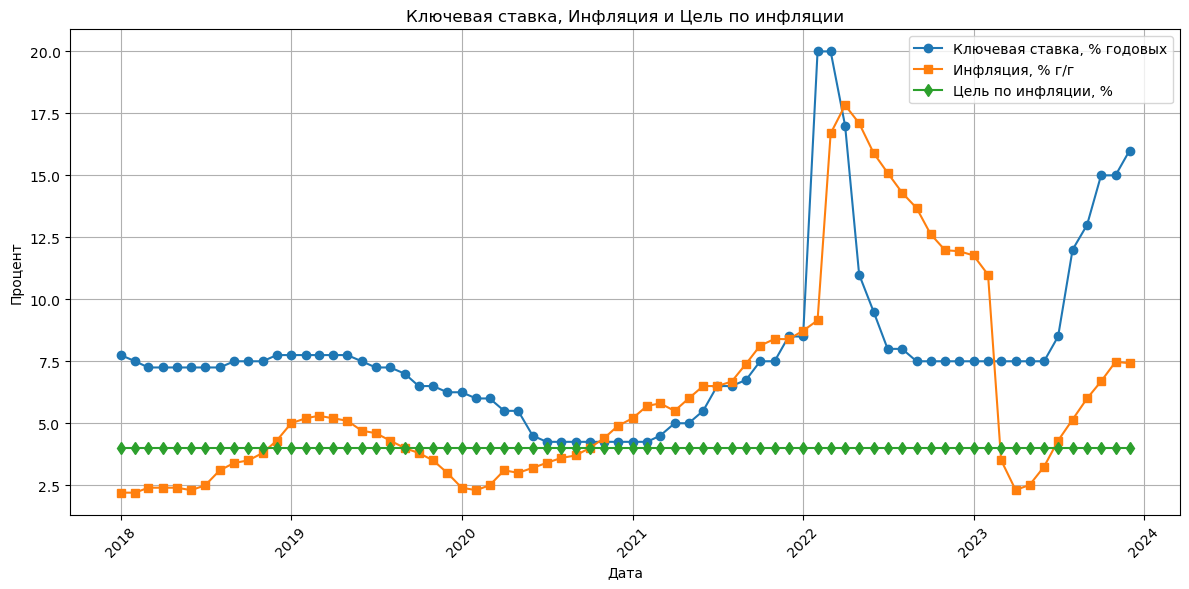

In [11]:
inflation_data = load_cbr_data(DATA_TYPE, START_DATE, END_DATE)
inflation_data[['Ключевая ставка, % годовых', 'Инфляция, % г/г', 'Цель по инфляции, %']] /=  100

inflation_data['Дата'] = inflation_data['Дата'].astype(str).map(convert_date)

# Преобразование строки в datetime
inflation_data['Дата'] = pd.to_datetime(inflation_data['Дата'], format='%Y-%m-%d', errors='coerce')

# Устанавливаем 'Дата' как индекс
inflation_data.set_index('Дата', inplace=True)

# Вывод данных для проверки
display(inflation_data.head())

# Визуализация данных
plt.figure(figsize=(12, 6))

# График ключевой ставки
plt.plot(inflation_data.index, inflation_data['Ключевая ставка, % годовых'], marker='o', label='Ключевая ставка, % годовых')
plt.plot(inflation_data.index, inflation_data['Инфляция, % г/г'], marker='s', label='Инфляция, % г/г')
plt.plot(inflation_data.index, inflation_data['Цель по инфляции, %'], marker='d', label='Цель по инфляции, %')

# Настройка графика
plt.xlabel('Дата')
plt.ylabel('Процент')
plt.title('Ключевая ставка, Инфляция и Цель по инфляции')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Отображение графика
plt.show()